<a href="https://www.kaggle.com/code/shamimahossain/news-headline-clickbait-classifer?scriptVersionId=108987498" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np 
import pandas as pd 
import nltk   
import matplotlib.pyplot as plt           
import random 
import os
from collections import Counter 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [2]:
DATA_DIR = "../input/clickbait-dataset/"

In [3]:
data_df = pd.read_csv(DATA_DIR + 'clickbait_data.csv')
data_df.head()

,headline,clickbait
0,Should I Get Bings,1
1,Which TV Female Friend Group Do You Belong In,1
2,"The New ""Star Wars: The Force Awakens"" Trailer...",1
3,"This Vine Of New York On ""Celebrity Big Brothe...",1
4,A Couple Did A Stunning Photo Shoot With Their...,1


In [4]:
data_df.loc[data_df['clickbait']==0].shape, data_df.loc[data_df['clickbait']==1].shape

((16001, 2), (15999, 2))

In [5]:
import re                                  # library for regular expression operations
import string                              # for string operations

from nltk.corpus import stopwords          # module for stop words that come with NLTK
from nltk.stem import PorterStemmer        # module for stemming
from nltk.tokenize import word_tokenize   # module for tokenizing strings

# Preprocessing

## Removing punctuation and lower casing words

In [6]:
def remove_punctuation(text):
    return "".join(["" if ch in string.punctuation else ch.lower() for ch in text])

In [7]:
data_df['headline'] = data_df['headline'].apply(remove_punctuation)

## Tokenizing

In [8]:
#tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,reduce_len=True)

# tokenize headlines
data_df['headline'] = data_df['headline'].apply(word_tokenize)

data_df.head()

,headline,clickbait
0,"[should, i, get, bings]",1
1,"[which, tv, female, friend, group, do, you, be...",1
2,"[the, new, star, wars, the, force, awakens, tr...",1
3,"[this, vine, of, new, york, on, celebrity, big...",1
4,"[a, couple, did, a, stunning, photo, shoot, wi...",1


## Removing Stop words

In [9]:
stopwords_english = set(stopwords.words('english'))
def clean_words(headline):
    return [
    word for word in headline
    if word not in stopwords_english
]  

In [10]:
data_df['headline'] = data_df['headline'].apply(clean_words)

In [11]:
data_df.head()

,headline,clickbait
0,"[get, bings]",1
1,"[tv, female, friend, group, belong]",1
2,"[new, star, wars, force, awakens, trailer, giv...",1
3,"[vine, new, york, celebrity, big, brother, fuc...",1
4,"[couple, stunning, photo, shoot, baby, learnin...",1


## Stemming

In [12]:
stemmer = PorterStemmer()
def words_stems(headline):
    return [
    stemmer.stem(word) for word in headline
]  

In [13]:
data_df['headline'] = data_df['headline'].apply(words_stems)

In [14]:
data_df.head()

,headline,clickbait
0,"[get, bing]",1
1,"[tv, femal, friend, group, belong]",1
2,"[new, star, war, forc, awaken, trailer, give, ...",1
3,"[vine, new, york, celebr, big, brother, fuck, ...",1
4,"[coupl, stun, photo, shoot, babi, learn, inope...",1


In [15]:
data_df.shape

(32000, 2)

# Building word-frequency dictionary

In [16]:
bait_words = data_df.loc[data_df['clickbait'] == 1]
normal_words = data_df.loc[data_df['clickbait'] == 0]

In [17]:
bait_freq = dict(Counter([val for sublist in bait_words['headline'] for val in sublist]))
normal_freq = dict(Counter([val for sublist in normal_words['headline'] for val in sublist]))
    

In [18]:
baits = random.sample(list(bait_freq), 10)
normal = random.sample(list(normal_freq), 10)


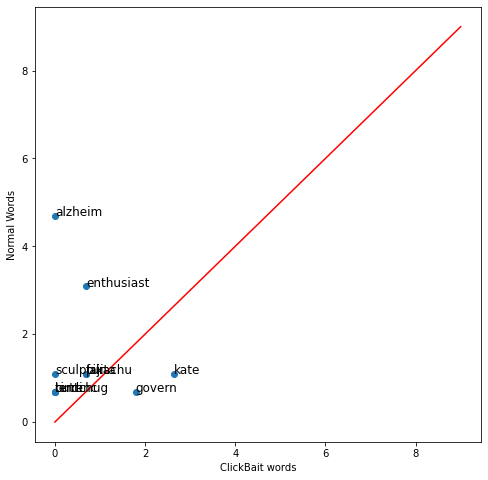

In [19]:
fig, ax = plt.subplots(figsize = (8, 8))

# convert positive raw counts to logarithmic scale. we add 1 to avoid log(0)
x = np.log([bait_freq[k] for k in baits])  

# do the same for the negative counts
y = np.log([normal_freq[x]+ 1 for x in normal]) 

data = list(zip(baits, normal))
# Plot a dot for each pair of words
ax.scatter(x, y)  

# assign axis labels
plt.xlabel("ClickBait words")
plt.ylabel("Normal Words")

# Add the word as the label at the same position as you added the points just before
for i in range(len(data)):
    ax.annotate(data[i][0], (x[i], y[i]), fontsize=12)

ax.plot([0, 9], [0, 9], color = 'red') # Plot the red line that divides the 2 areas.
plt.show()

# Extracting Features

In [20]:
data_df['bias'] = 1
data_df['bait'] = 0
data_df['normal'] = 0

In [21]:
def count_bait(headline):
    count = 0
    for word in headline:
        if word in bait_freq:
            count += bait_freq[word]
    return count
def count_normal(headline):
    count = 0
    for word in headline:
        if word in normal_freq:
            count += normal_freq[word]
    return count

In [22]:
data_df['bait'] = data_df['headline'].apply(count_bait)
data_df['normal'] = data_df['headline'].apply(count_normal)

In [23]:
data_df.head()

,headline,clickbait,bias,bait,normal
0,"[get, bing]",1,1,394,112
1,"[tv, femal, friend, group, belong]",1,1,486,230
2,"[new, star, war, forc, awaken, trailer, give, ...",1,1,1171,1226
3,"[vine, new, york, celebr, big, brother, fuck, ...",1,1,1151,1084
4,"[coupl, stun, photo, shoot, babi, learn, inope...",1,1,728,186


In [24]:
train_df = data_df[['clickbait', 'bias', 'bait', 'normal']]
X = train_df.drop(['clickbait'], axis=1)
y = train_df['clickbait']

In [25]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42)

In [26]:
clf = LogisticRegression(random_state=1234).fit(X_train, y_train)

In [27]:
clf.score(X_train, y_train)

0.9014583333333334

In [28]:
clf.score(X_test, y_test)

0.8884375